# 1.2 如何从零手动实现Transformer？

完成以下内容的数学公式，完成对应的代码，通过`test_model.py`的所有测试函数
- **Linear**：实现线性变换（全连接层），输入输出做矩阵乘法加偏置。
- **Embedding**：把 token id 查表映射为向量，作为模型输入。
- **silu**：实现 SiLU（Swish）激活函数。
- **SwiGLU**：前馈结构，w1(x) 经过 silu 后与 w2(x) 逐元素相乘，再过 w3 还原维度。
- **RMSNorm**：对每个样本的特征向量做均方根归一化，并有可学习缩放参数。
- **MultiheadSelfAttention**：实现多头自注意力，Q、K、V 分头计算注意力后合并输出。
- **run_scaled_dot_product_attention**：实现缩放点积注意力（softmax((QK^T)/sqrt(d_k))V）。
- **run_rope**：实现 RoPE 旋转位置编码，对 Q、K 做旋转增强序列建模。
- **TransformerBlock**：一个完整的 Transformer Block，包含注意力、归一化、前馈和残差。
- **Transformer**：完整的 Transformer 语言模型，包含嵌入、多个 Block 和输出层。

## 一、通用结构层

### 1.1 线性层

线性层的公式如下：

$$
y = xW^T + b
$$

其中：
- $x$ 表示输入张量，形状为 $(..., d_{in})$，即最后一维是输入特征维度。
- $W$ 表示权重参数矩阵，形状为 $(d_{out}, d_{in})$，$W^T$ 表示转置，形状为 $(d_{in}, d_{out})$。
- $b$ 表示偏置参数，形状为 $(d_{out})$。
- $y$ 表示输出张量，形状为 $(..., d_{out})$。

线性层的作用是将输入的每个特征向量 $x$ 通过一个线性变换（仿射变换）映射到新的空间，常用于特征投影、维度变换等场景。

### 1.2 嵌入层

嵌入层（Embedding Layer）用于将离散的 token id 映射为连续的向量表示。其数学表达为：

$$
\text{Embedding}(i) = E[i]
$$

其中：
- $i$ 表示输入的 token 索引（整数），可以是一维或多维张量。
- $E$ 表示嵌入矩阵，形状为 $(\text{num\_embeddings}, \text{embedding\_dim})$，即词表大小 × 嵌入维度。
- $E[i]$ 表示取出第 $i$ 行，得到该 token 的嵌入向量。

嵌入层的作用是将每个 token id 映射为一个稠密的向量，使得模型能够对离散的 token 进行连续空间的建模和学习。

### 1.3 SiLU函数讲解

SiLU（Sigmoid Linear Unit）函数是一种常用的激活函数，也被称为 Swish。其数学表达式为：

$$
\text{SiLU}(x) = x \cdot \sigma(x)
$$

其中 $\sigma(x)$ 表示 Sigmoid 函数，即 $\sigma(x) = \frac{1}{1 + e^{-x}}$。

SiLU 的主要特点是输出平滑且非单调，有助于缓解梯度消失问题。与 ReLU 相比，SiLU 在负区间不会直接置零，而是平滑衰减，这有助于信息流动和模型收敛。

在 PyTorch 中，可以通过 `torch.nn.functional.silu(x)` 或 `F.silu(x)` 实现。


/var/folders/wf/80j2r9qx5f3156_xs74f895w0000gn/T/ipykernel_57716/3347467143.py:39: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/80j2r9qx5f3156_xs74f895w0000gn/T/ipykernel_57716/3347467143.py:39: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/80j2r9qx5f3156_xs74f895w0000gn/T/ipykernel_57716/3347467143.py:39: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/80j2r9qx5f3156_xs74f895w0000gn/T/ipykernel_57716/3347467143.py:39: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wf/80j2r9qx5f3156_xs74f895w0000gn/T/ipykernel_57716/3347467143.py:39: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/apple1/Deskto

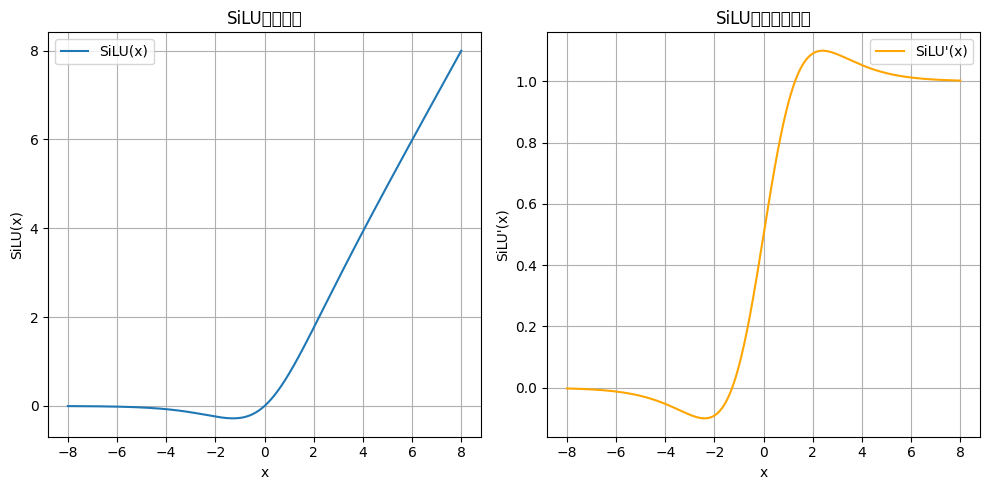

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 生成输入数据
x = np.linspace(-8, 8, 400)

# 计算SiLU函数值
# SiLU(x) = x * sigmoid(x)
def silu(x):
    return x * (1 / (1 + np.exp(-x)))

y = silu(x)

# 计算SiLU的导数
# SiLU(x) 的导数为: sigmoid(x) * (1 + x * (1 - sigmoid(x)))
sigmoid_x = 1 / (1 + np.exp(-x))
dy = sigmoid_x * (1 + x * (1 - sigmoid_x))

plt.figure(figsize=(10, 5))

# 绘制SiLU函数
plt.subplot(1, 2, 1)
plt.plot(x, y, label="SiLU(x)")
plt.title("SiLU函数图像")
plt.xlabel("x")
plt.ylabel("SiLU(x)")
plt.grid(True)
plt.legend()

# 绘制SiLU导数
plt.subplot(1, 2, 2)
plt.plot(x, dy, color="orange", label="SiLU'(x)")
plt.title("SiLU函数导数图像")
plt.xlabel("x")
plt.ylabel("SiLU'(x)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### 1.3SwiGLU层

SwiGLU 层是一种用于 Transformer 前馈神经网络（FFN）部分的激活结构，全称为 Swish-Gated Linear Unit。它的主要思想是结合门控机制和非线性激活函数，提升模型的表达能力。

其结构如下：

1. 输入 $x$ 先分别通过两个线性变换（$w_1$ 和 $w_2$），得到 $w_1(x)$ 和 $w_2(x)$，它们的输出 shape 都是 $(..., d_{ff})$。
2. 对 $w_1(x)$ 施加 SiLU（Swish）激活函数，得到 $\text{silu}(w_1(x))$。SiLU 的公式为：$\text{silu}(x) = x \cdot \sigma(x)$，其中 $\sigma(x)$ 是 sigmoid 函数。
3. 将 $\text{silu}(w_1(x))$ 和 $w_2(x)$ 做逐元素相乘，得到门控后的结果。
4. 最后通过 $w_3$ 线性变换，将维度还原回 $d_{model}$。

公式表达为：
$$
\text{SwiGLU}(x) = w_3\left( \text{silu}(w_1(x)) \odot w_2(x) \right)
$$
其中 $\odot$ 表示逐元素相乘。

SwiGLU 的优点在于：
- 引入了门控机制（通过 $w_2(x)$），增强了模型的非线性表达能力；
- SiLU 激活函数相比 ReLU 更平滑，有助于梯度流动和模型收敛；
- 实践中，SwiGLU 通常优于传统的 ReLU 或 GLU 结构。

在 PyTorch 中，SiLU 激活可以通过 `F.silu(x)` 或 `torch.nn.functional.silu(x)` 实现。


### 1.4 RMSNorm层

RMSNorm（Root Mean Square Layer Normalization）是一种归一化方法，常用于Transformer等模型中。其核心思想是对每个样本的最后一维（通常是特征维度）做均方根归一化，即对`d_model`纬度做归一化。具体公式如下：

设输入张量为 $x \in \mathbb{R}^{*, d}$，其中 $d$ 是特征维度，$*$ 表示任意批量和序列维度。

1. 计算均方根（RMS）：
$$
\text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2}
$$

2. 归一化：
$$
\hat{x} = \frac{x}{\text{RMS}(x) + \epsilon}
$$
其中 $\epsilon$ 是一个很小的常数，防止除零。

3. 可学习缩放：
$$
y = \hat{x} \odot \text{weight}
$$
其中 $\text{weight} \in \mathbb{R}^d$ 是可学习参数，$\odot$ 表示逐元素相乘。

因此，RMSNorm 的输出为
$$
\text{RMSNorm}(x) = \frac{x}{\sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2} + \epsilon} \odot \text{weight}
$$

RMSNorm 相比 LayerNorm 更简单，计算量更小，且在大模型中表现良好。


### 1.5 自注意力层

以下是单头自注意力（Single-Head Self-Attention）的公式推导及详细 Shape 备注（标注每个张量的维度变化）：

#### 1. 输入定义

输入序列张量 $X$：
$$
X \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_\text{model}}
$$
- $\text{batch\_size}$：批处理样本数（如32）
- $\text{seq\_len}$：序列长度（如512个token）
- $d_\text{model}$：模型隐藏层维度（如768）

#### 2. 线性投影计算 Q, K, V

通过可学习的投影矩阵 $W_Q, W_K, W_V$ 将输入 $X$ 映射到 Query（$Q$）、Key（$K$）、Value（$V$）空间：
$$
\begin{aligned}
Q &= X W_Q \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
K &= X W_K \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
V &= X W_V \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k}
\end{aligned}
$$
其中 $W_Q, W_K, W_V \in \mathbb{R}^{d_\text{model} \times d_k}$，$d_k$ 为每个注意力头的维度（单头时 $d_k = d_\text{model}$，多头时 $d_k = d_\text{model}/h$）。

#### 3. 计算注意力分数（Attention Scores）

通过 Query 和 Key 的相似度计算注意力分数：
$$
\text{Scores} = \frac{Q K^\top}{\sqrt{d_k}} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times \text{seq\_len}}
$$
其中 $Q K^\top$ 表示对每个 Query 与所有 Key 的点积，$\sqrt{d_k}$ 为缩放因子，防止点积过大导致 softmax 梯度消失。

```{note}
最后两个维度seq,seq构成的矩阵代表了token之间的关系，在语言模型训练/生成时，要求每个位置只能看到它自己和它之前的 token，不能看到未来的信息。这时 mask 是一个下三角矩阵（对角线及其以下为1，其余为0）。这样可以防止“作弊”，保证生成的每个 token 只依赖于历史。 
```

多维矩阵相乘其实除了最后两个维度代表矩阵，前面的维度都等同于路径索引，最终两个高维矩阵做矩阵乘法是对后两个维度进行乘法，矩阵乘法可以用来表示两个向量的相似度，如下图所示
![矩阵乘法与相似度](./image/1.2_1.png)

#### 4. Softmax 归一化

对注意力分数进行 softmax 归一化，得到注意力权重（概率分布）：
$$
\text{Attention Weights} = \text{softmax}(\text{Scores}) \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times \text{seq\_len}}
$$
输出：每个位置对序列中所有位置的关注权重（每行和为1）。

#### 5. 加权求和（Context Vector）

用注意力权重对 Value ($V$) 加权求和，得到每个位置的上下文表示：
$$
\text{Output} = \text{Attention Weights} \cdot V \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k}
$$
即通过矩阵乘法，将序列中其他位置的信息融合到每个位置的输出中。

#### 6. 单头自注意力的完整公式（含 Shape 备注）

$$
\begin{aligned}
Q &= X W_Q \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
K &= X W_K \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
V &= X W_V \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
\text{Attention}(Q, K, V) &= \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right) V \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k}
\end{aligned}
$$

关键点总结

- 输入输出维度一致：输入 $X \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_\text{model}}$，输出 $\in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k}$。单头时 $d_k = d_\text{model}$，因此输出维度与输入一致。
- 注意力机制的核心：通过 Query-Key 相似度动态分配权重，聚合 Value 信息。
- 缩放因子 $\sqrt{d_k}$：稳定训练，防止梯度消失。
- Softmax 归一化：确保注意力权重是有效的概率分布。


#### 7. 多头自注意力的完整公式（含 Shape 备注）

$$
\begin{aligned}
&\text{对每个头 $h=1,\dots,H$：} \\
&\quad Q_h = X W_Q^{(h)} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
&\quad K_h = X W_K^{(h)} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
&\quad V_h = X W_V^{(h)} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
&\quad \text{head}_h = \text{softmax}\left(\frac{Q_h K_h^\top}{\sqrt{d_k}}\right) V_h \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_k} \\
&\text{拼接所有头：} \\
&\quad \text{MultiHead}(X) = \text{Concat}(\text{head}_1, \dots, \text{head}_H) W_O \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_\text{model}}
\end{aligned}
$$

- $H$：头数，$d_\text{model} = H \times d_k$
- $W_Q^{(h)}, W_K^{(h)}, W_V^{(h)} \in \mathbb{R}^{d_\text{model} \times d_k}$：每个头的参数
- $W_O \in \mathbb{R}^{H d_k \times d_\text{model}}$：输出投影参数

关键点总结

- 多头机制：每个头独立学习不同的注意力，最后拼接后再线性变换，增强模型表达能力。
- 输入输出 shape：输入 $X \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d_\text{model}}$，输出 shape 与输入一致。
- 多头并行：可并行计算，提升效率。



### 8.Rope（旋转位置编码）

```{danger}
重点理解
```

#### 8.1 绝对位置编码（APE）

绝对位置编码（Absolute Positional Encoding）是指为序列中每个位置分配一个唯一的、固定的向量，使得模型能够区分不同的序列位置。常见的做法是使用正弦和余弦函数生成不同频率的编码，具体公式如下：

$$
\begin{aligned}
PE_{(p, 2i)} &= \sin\left(\frac{p}{10000^{2i/d}}\right) \\
PE_{(p, 2i+1)} &= \cos\left(\frac{p}{10000^{2i/d}}\right)
\end{aligned}
$$

其中 $p$ 表示位置，$i$ 表示维度索引，$d$ 为编码维度。这样每个位置 $p$ 都有一个 $d$ 维的向量，编码了其绝对位置信息。


#### 8.2 相对位置编码（RPE）

相对位置编码（Relative Positional Encoding）关注的是序列中各元素之间的相对距离，而不是每个元素的绝对位置。其核心思想是让模型能够感知“当前位置与其他位置的距离”，从而更好地建模序列中的相对关系。常见做法是在注意力计算时引入相对位置信息：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top + QR^\top}{\sqrt{d_k}}\right)V
$$

其中 $R$ 表示相对位置的嵌入矩阵。这样，注意力分数不仅依赖于内容相似度，还包含了相对位置信息，有助于提升模型对顺序和结构的理解能力。$R$ 是一个可学习的相对位置嵌入表，通常初始化为随机值，训练过程中不断优化。


#### 8.3 旋转位置编码（ROPE）

Rope（旋转位置编码）的核心思想是将位置信息通过旋转变换编码到向量空间中。具体公式如下：

设输入为 $X \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d}$，其中 $d$ 为偶数。对于每个位置 $p$ 和每个偶数索引 $i$，定义一组频率 $\theta_i = 10000^{-2i/d}$。

将 $X$ 的最后一维两两分组，记为 $(x_{p,2i}, x_{p,2i+1})$，则旋转编码为：

$$
\begin{aligned}
\text{Rope}(x_{p,2i}, x_{p,2i+1}) =
\big(
x_{p,2i} \cos(\theta_i p) - x_{p,2i+1} \sin(\theta_i p),\;
x_{p,2i} \sin(\theta_i p) + x_{p,2i+1} \cos(\theta_i p)
\big)
\end{aligned}
$$

这样，经过 Rope 变换后，向量的每一对分量都根据其位置 $p$ 进行了旋转，编码了绝对和相对位置信息。其中，绝对位置信息是显式的（每个位置旋转不同角度），相对位置信息是隐式的（旋转操作的性质使得注意力计算能感知相对位置）。


### 9.Transformer Block
Transformer Block（变换器模块）是Transformer模型的基本结构单元。每个Block通常包含多头自注意力机制（Multi-Head Self-Attention）和前馈神经网络（Feed Forward Network），并配有残差连接（Residual Connection）和层归一化（Layer Normalization）。

其主要计算流程如下：

设输入为 $X \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_len} \times d}$，则

1. 多头自注意力机制：
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$
其中 $Q = XW^Q, K = XW^K, V = XW^V$，$W^Q, W^K, W^V$ 为可学习参数。

2. 残差连接与层归一化：
$$
\text{Out}_1 = \text{LayerNorm}(X + \text{MultiHeadAttention}(X))
$$

3. 前馈神经网络（FFN）：
$$
\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2
$$

4. 再次残差连接与层归一化：
$$
\text{Out}_2 = \text{LayerNorm}(\text{Out}_1 + \text{FFN}(\text{Out}_1))
$$

通过堆叠多个Transformer Block，模型能够高效地建模序列中的复杂依赖关系。
